In [1]:
#the idea is we need to load the models
# import sys
# sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import torch
# from evals.evals_utils import Evals

#actually let's first try the manual load
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from torch.utils.data import DataLoader
# from src.dataloaders.datasets.ccre_dataset import CcreDataset
# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.tasks.decoders import ProfileDecoder
import yaml


In [2]:
tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
    characters=['A', 'C', 'G', 'T', 'N'],
    model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
    add_special_tokens=False,
    padding_side='left'
)

cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/profile.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

In [3]:
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config
d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
print(d_output, model_cfg, train_cfg)
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-15/07-49-23-830590/checkpoints/86-val_loss=1472.48523.ckpt'

1 {'_name_': 'dna_embedding', 'd_model': 128, 'n_layer': 2, 'd_inner': 512, 'vocab_size': 16, 'resid_dropout': 0.0, 'embed_dropout': 0.1, 'fused_mlp': False, 'fused_dropout_add_ln': False, 'residual_in_fp32': True, 'pad_vocab_size_multiple': 1, 'return_hidden_state': True, 'layer': {'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 1026, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}} {'d_output': 1}


In [4]:
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
state_dict = torch.load(ckpt_path, map_location='cpu')

In [5]:
state_dict['state_dict']

OrderedDict([('model.backbone.embeddings.word_embeddings.weight',
              tensor([[ 0.9429, -0.3050,  1.3067,  ...,  1.0830,  0.9085, -1.2386],
                      [ 0.5170, -1.4734,  0.9022,  ...,  0.5446,  0.5742, -0.8835],
                      [ 0.9428, -0.3050,  1.3067,  ...,  1.0830,  0.9085, -1.2386],
                      ...,
                      [ 0.9428, -0.3050,  1.3067,  ...,  1.0830,  0.9085, -1.2386],
                      [ 0.9428, -0.3050,  1.3067,  ...,  1.0830,  0.9085, -1.2386],
                      [ 0.9428, -0.3050,  1.3067,  ...,  1.0830,  0.9085, -1.2386]])),
             ('model.backbone.layers.0.mixer.out_proj.weight',
              tensor([[-0.0093, -0.0115,  0.0037,  ...,  0.0412,  0.0850, -0.0243],
                      [-0.0325,  0.0245, -0.0056,  ..., -0.0217,  0.0092,  0.0718],
                      [ 0.0179, -0.0046,  0.0085,  ...,  0.0492, -0.0199, -0.0265],
                      ...,
                      [ 0.0177,  0.0297, -0.0114,  ..., -0

In [6]:
decoder

ProfileDecoder(
  (output_transform_counts): Linear(in_features=128, out_features=1, bias=True)
  (output_transform_profile): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform_counts.weight'] = model_state_dict.pop('decoder.0.output_transform_counts.weight')
decoder_state_dict['output_transform_counts.bias'] = model_state_dict.pop('decoder.0.output_transform_counts.bias')
decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [8]:
#so this setup is great, it enables an easy and uniform way to decide if we want to add the bias or not to the outputs of the decoder!
#the other things we need to do are load the dataset, and so given a sequence, we save all the outputs
#the one we loaded has a bias model of none, so we don't have to worry about it! let's now check to see an output

#we need to load the dataset
from src.dataloaders.datasets.profile_atac import ProfileATAC
dataset = ProfileATAC(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='False')

In [21]:
import numpy as np
split = 'test'
data_path = f'/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/{split}/'
#what we do is load in the numpy arrays
peak_seqs = np.load(data_path+'peak_seqs.npy')
peak_cts = np.load(data_path+'peak_cts.npy')
peak_coords = np.load(data_path+'peak_coords.npy')
nonpeak_seqs = np.load(data_path+'nonpeak_seqs.npy', allow_pickle=True) #oh, obviously these 3 are none...
nonpeak_cts = np.load(data_path+'nonpeak_cts.npy', allow_pickle=True)
nonpeak_coords = np.load(data_path+'nonpeak_coords.npy', allow_pickle=True)
print(peak_seqs.shape, peak_cts.shape, peak_coords.shape, nonpeak_seqs.shape, nonpeak_cts.shape, nonpeak_coords.shape)

(26172, 1024, 4) (26172, 800) (26172, 4) () () ()


In [22]:
print(nonpeak_seqs) #so for test no nonpeaks

None


In [23]:
data_path = f'/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/valid/'
np.load(data_path+'nonpeak_seqs.npy') #exists for valid...

array([[[0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0]],

       [[0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        ...,
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0]],

       ...,

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]],

       [[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]]], dtype=int8)

In [9]:
#I fixed it, dataset should be good now
dataset[0][0][0].shape
#so here's how the dataset works
#first you choose the index, then you choose input or output. for input, gives sequence, then onehot sequence
#for output gives the profile and counts

torch.Size([1024])

In [10]:
dataset[0][1][0].shape #this is the proper 800 output!!

torch.Size([800])

In [14]:
#now let's test an input and output
out1 = backbone(dataset[0][0][0].unsqueeze(0).to(device))
print(len(out1))
print(out1[0].shape, out1[1]) #out1[1] is just none, don't care about it

2
torch.Size([1, 1024, 128]) None


In [15]:
#now we have the profile level stuff so we have to go through network then cut off
out2 = decoder(out1[0])
print(len(out2))
print(out2[0].shape, out2[1].shape) #so this is the output of the decoder, the profile and the counts

2
torch.Size([1, 1024, 1]) torch.Size([1, 1])


In [21]:
#the final thigns we do are squeeze it and cut to the middle 800 then convert to numpy
true_counts = dataset[0][1][0].unsqueeze(0).to(device)
# print(true_counts.shape)
if out2[0].shape[1] > true_counts.shape[1]:
    #then we cut off from both ends until we get the same size
    diff = out2[0].shape[1] - true_counts.shape[1]
    start = diff // 2
    end = start + true_counts.shape[1]
    profile_out = out2[0][:, start:end].squeeze()
print(profile_out.shape)

torch.Size([800])


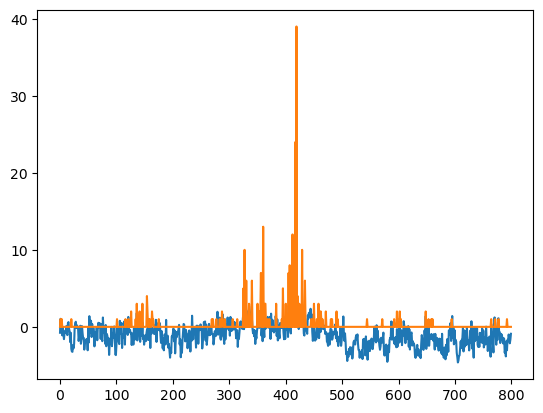

In [24]:
#let's plot this
import matplotlib.pyplot as plt
plt.plot(profile_out.cpu().detach().numpy())
plt.plot(true_counts.squeeze().cpu().detach().numpy())

In [26]:
#This is absolutely terrible...
#let's now look at the other output
print(out2[1], dataset[0][1][1])
#this is actually quite decent!

tensor([[5.9441]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([5.6454])


In [27]:
#let's go through all the dataset members and save out the results
#we need to save out the profile and counts
len(dataset)

26172

In [34]:
import numpy as np
from tqdm import tqdm
counts_matrix = np.zeros((len(dataset)))
profile_matrix = np.zeros((len(dataset), 800))
print(counts_matrix.shape, profile_matrix.shape)
for i in tqdm(range(len(dataset))):
    out1 = backbone(dataset[i][0][0].unsqueeze(0).to(device))
    out2 = decoder(out1[0])
    true_counts = dataset[i][1][0].unsqueeze(0).to(device)
    if out2[0].shape[1] > true_counts.shape[1]:
        #then we cut off from both ends until we get the same size
        diff = out2[0].shape[1] - true_counts.shape[1]
        start = diff // 2
        end = start + true_counts.shape[1]
        profile_out = out2[0][:, start:end].squeeze()
    #save out the profile and counts
    # print(profile_out.shape)
    # print(out2[1])
    # break
    counts_matrix[i] = out2[1].item()
    profile_matrix[i] = profile_out.cpu().detach().numpy()

(26172,) (26172, 800)


In [37]:
#ensure none of the data is 0
print(np.sum(counts_matrix == 0)) #so all are given an output!

0


In [36]:
#let's save this out now as a compressed numpy array
np.savez_compressed('/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/profile_nobias.npz', counts=counts_matrix, profile=profile_matrix)

In [ ]:
#let's redo this above but batch to see how much faster it is
#eh whatever we'll just use dataloader, no need to test this
counts_matrix_og = counts_matrix; profile_matrix_og = profile_matrix
counts_matrix = np.zeros((len(dataset)))
profile_matrix = np.zeros((len(dataset), 800))
for i in tqdm(range(len(dataset))):
    out1 = backbone(dataset[i][0][0].unsqueeze(0).to(device))
    out2 = decoder(out1[0])
    true_counts = dataset[i][1][0].unsqueeze(0).to(device)
    if out2[0].shape[1] > true_counts.shape[1]:
        #then we cut off from both ends until we get the same size
        diff = out2[0].shape[1] - true_counts.shape[1]
        start = diff // 2
        end = start + true_counts.shape[1]
        profile_out = out2[0][:, start:end].squeeze()
    #save out the profile and counts
    # print(profile_out.shape)
    # print(out2[1])
    # break
    counts_matrix[i] = out2[1].item()
    profile_matrix[i] = profile_out.cpu().detach().numpy()

# now with the bias model

In [2]:
#restarted the kernel, now we can do the same thing but we want to use the bias model one this time
import torch
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from torch.utils.data import DataLoader
from src.tasks.decoders import ProfileDecoder
import yaml

tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
    characters=['A', 'C', 'G', 'T', 'N'],
    model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
    add_special_tokens=False,
    padding_side='left'
)

cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/profile.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config
d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
# print(d_output, model_cfg, train_cfg)
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-15/07-29-09-511172/checkpoints/86-val_loss=887.93817.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')


In [3]:
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
state_dict = torch.load(ckpt_path, map_location='cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform_counts.weight'] = model_state_dict.pop('decoder.0.output_transform_counts.weight')
decoder_state_dict['output_transform_counts.bias'] = model_state_dict.pop('decoder.0.output_transform_counts.bias')
decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [4]:
#now we load in the bias model


In [5]:
#let's plot an output with and without the bias, see how much the model actually adds to it...

bias_model_path = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/models/bias_model_scaled.h5'
#load it
import sys
sys.path.append('/data/leslie/sarthak/chrombpnet/')
from bpnetlite.bpnet import BPNet
#the location is /data/leslie/sarthak/chrombpnet/bpnetlite/bpnet.py
model = BPNet.from_chrombpnet(bias_model_path,trimming=(1024-800)//2)
#eval mode and move it
model.eval().to(device)

BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [6]:
next(model.parameters()).device #so it's on the right device

device(type='cuda', index=0)

In [7]:
#now let's look at an example
from src.dataloaders.datasets.profile_atac import ProfileATAC
dataset = ProfileATAC(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='False')


In [8]:
#now let's test an input and output
out1 = backbone(dataset[0][0][0].unsqueeze(0).to(device))
print(len(out1))
print(out1[0].shape, out1[1]) #out1[1] is just none, don't care about it

2
torch.Size([1, 1024, 128]) None


In [9]:
#now we have the profile level stuff so we have to go through network then cut off
out2 = decoder(out1[0])
print(len(out2))
print(out2[0].shape, out2[1].shape) #so this is the output of the decoder, the profile and the counts

2
torch.Size([1, 1024, 1]) torch.Size([1, 1])


In [10]:
#the final thigns we do are squeeze it and cut to the middle 800 then convert to numpy
true_counts = dataset[0][1][0].unsqueeze(0).to(device)
# print(true_counts.shape)
if out2[0].shape[1] > true_counts.shape[1]:
    #then we cut off from both ends until we get the same size
    diff = out2[0].shape[1] - true_counts.shape[1]
    start = diff // 2
    end = start + true_counts.shape[1]
    profile_out = out2[0][:, start:end].squeeze()
print(profile_out.shape)

torch.Size([800])


In [11]:
bias_out = model(dataset[0][0][1].unsqueeze(0).to(device))

In [12]:
print(bias_out[1].shape, bias_out[0].shape)

torch.Size([1, 1]) torch.Size([1, 1, 800])


In [13]:
#now we add to profile_out and the out[1] our bias output
print(out2[1]) #so this does indeed do the heavy lifting!
print(bias_out[1])
print(dataset[0][1][1])
#but remember we have to use torch logsumexp
a=torch.logsumexp(torch.cat([out2[1], bias_out[1]], dim=1), dim=1, keepdim=True)
print(a)

tensor([[5.6410]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[4.0684]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([5.6454])
tensor([[5.8296]], device='cuda:0', grad_fn=<LogsumexpBackward0>)


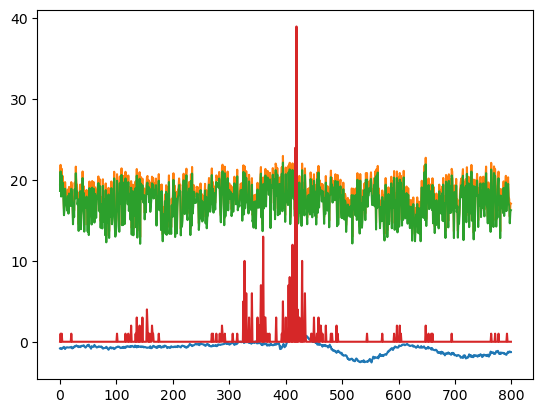

In [20]:
#now let's look at the profiles
import matplotlib.pyplot as plt

plt.plot(profile_out.cpu().detach().numpy())
plt.plot(bias_out[0].squeeze().cpu().detach().numpy())
plt.plot(bias_out[0].squeeze().cpu().detach().numpy() + profile_out[0].squeeze().cpu().detach().numpy())
plt.plot(true_counts.squeeze().cpu().detach().numpy())

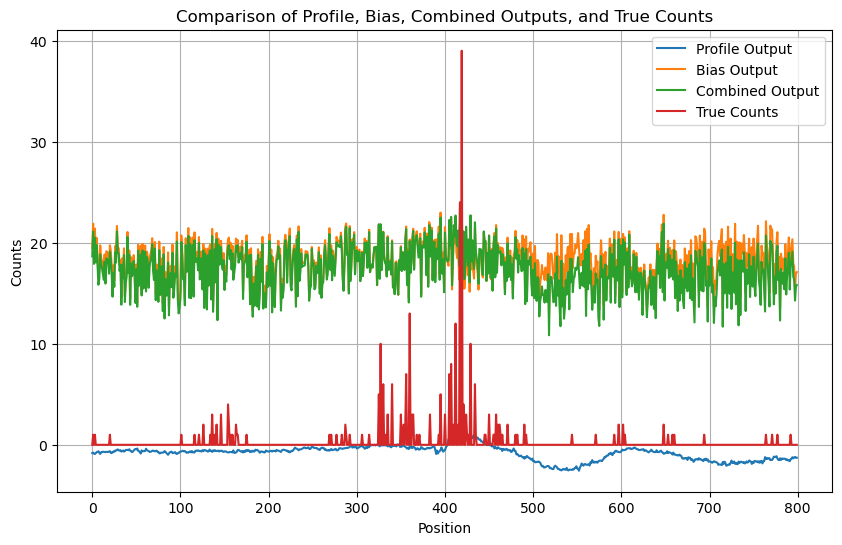

In [15]:
import matplotlib.pyplot as plt
profile_out_np = profile_out.cpu().detach().numpy()
bias_out_np = bias_out[0].squeeze().cpu().detach().numpy()
combined_out_np = bias_out_np + profile_out_np
true_counts_np = true_counts.squeeze().cpu().detach().numpy()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series with a label
plt.plot(profile_out_np, label='Profile Output')
plt.plot(bias_out_np, label='Bias Output')
plt.plot(combined_out_np, label='Combined Output')
plt.plot(true_counts_np, label='True Counts')

# Add a legend
plt.legend(loc='best')

# Add axis labels and a title
plt.xlabel('Position')
plt.ylabel('Counts')
plt.title('Comparison of Profile, Bias, Combined Outputs, and True Counts')

# Add grid for better readability
plt.grid(True)

# Optionally, customize the plot style
# plt.style.use('seaborn-darkgrid')

# Show the plot
plt.show()

In [25]:
#now do the softmax
print(profile_out.shape)
print(bias_out[0].shape)

sum_out = profile_out + bias_out[0].squeeze()
print(sum_out.shape)
print(sum_out.softmax(dim=0).shape)
print(sum_out.softmax(dim=0).sum())

torch.Size([800])
torch.Size([1, 1, 800])
torch.Size([800])
torch.Size([800])
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


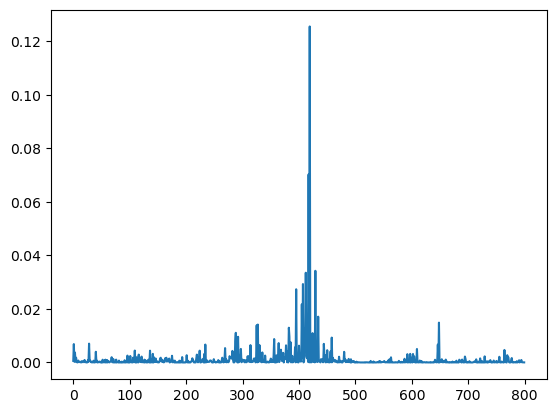

In [26]:
soft_out = sum_out.softmax(dim=0)
plt.plot(soft_out.cpu().detach().numpy())
#oh... wait what?

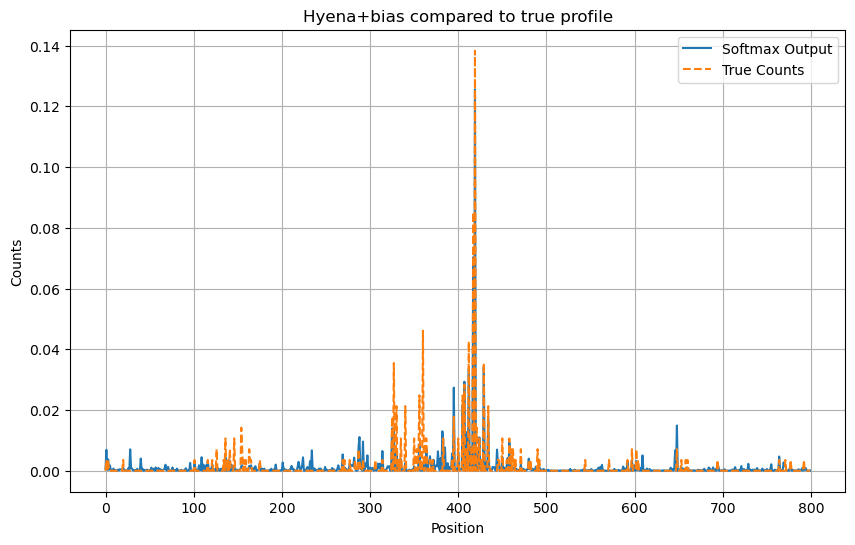

In [30]:
soft_out_np = soft_out.cpu().detach().numpy()
true_counts_np = true_counts.squeeze().cpu().detach().numpy()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series with a label
soft_out_np = soft_out_np / soft_out_np.sum()
plt.plot(soft_out_np, label='Softmax Output', )
true_counts_np = true_counts_np / true_counts_np.sum()
plt.plot(true_counts_np, label='True Counts', linestyle='--')

# Add a legend
plt.legend(loc='best')

# Add axis labels and a title
plt.xlabel('Position')
plt.ylabel('Counts')
plt.title('Hyena+bias compared to true profile')

# Add grid for better readability
plt.grid(True)

In [24]:
#finally let's use torch nll loss to see how large the loss is for this
def cbpnet_multinomial_nll(logits,true_counts, len_batch=None, ignore_index=-100, mask = True):

    """A loss function based on the multinomial negative log-likelihood.
    modified by me to include things like doing thE log softmax and deal with more complex tracking

    This loss function takes in a tensor of normalized log probabilities such
    that the sum of each row is equal to 1 (e.g. from a log softmax) and
    an equal sized tensor of true counts and returns the probability of
    observing the true counts given the predicted probabilities under a
    multinomial distribution. Can accept tensors with 2 or more dimensions
    and averages over all except for the last axis, which is the number
    of categories.

    Adapted from Alex Tseng.

    Parameters
    ----------
    logps: torch.tensor, shape=(n, ..., L)
        A tensor with `n` examples and `L` possible categories. 

    true_counts: torch.tensor, shape=(n, ..., L)
        A tensor with `n` examples and `L` possible categories.

    Returns
    -------
    loss: float
        The multinomial log likelihood loss of the true counts given the
        predicted probabilities, averaged over all examples and all other
        dimensions.
    """
    if isinstance(logits, tuple): #for wandb tracking, it inputs logits here, since then it's a tuple
        logits = logits[0]
        true_counts = true_counts[0]
    #we also need to make sure that we have the right shape
    logits = logits.squeeze(); true_counts = true_counts.squeeze()
    # if logits.shape[1] > true_counts.shape[1]: #added it in the tasks instead
    #     #then we cut off from both ends until we get the same size
    #     diff = logits.shape[1] - true_counts.shape[1]
    #     start = diff // 2
    #     end = start + true_counts.shape[1]
    #     logits = logits[:, start:end]
        # logits = logits[:,diff//2:-diff//2]
    logps = torch.log_softmax(logits, dim=-1)
    log_fact_sum = torch.lgamma(torch.sum(true_counts, dim=-1) + 1)
    log_prod_fact = torch.sum(torch.lgamma(true_counts + 1), dim=-1)
    log_prod_exp = torch.sum(true_counts * logps, dim=-1)
    return (-log_fact_sum + log_prod_fact - log_prod_exp).mean()

#let's test this
cbpnet_multinomial_nll(profile_out+bias_out[0], true_counts)
#this loss is smaller than average? wtf??

tensor(313.3624, device='cuda:0', grad_fn=<MeanBackward0>)

In [29]:
#let's now go through and save out the results
from tqdm import tqdm
import numpy as np
counts_matrix = np.zeros((len(dataset)))
profile_matrix = np.zeros((len(dataset), 800))
print(counts_matrix.shape, profile_matrix.shape)
for i in tqdm(range(len(dataset))):
    out1 = backbone(dataset[i][0][0].unsqueeze(0).to(device))
    out2 = decoder(out1[0])
    true_counts = dataset[i][1][0].unsqueeze(0).to(device)
    if out2[0].shape[1] > true_counts.shape[1]:
        #then we cut off from both ends until we get the same size
        diff = out2[0].shape[1] - true_counts.shape[1]
        start = diff // 2
        end = start + true_counts.shape[1]
        profile_out = out2[0][:, start:end].squeeze()
    bias_out = model(dataset[i][0][1].unsqueeze(0).to(device))
    combined_out = profile_out + bias_out[0].squeeze()
    counts_out = torch.logsumexp(torch.cat([out2[1], bias_out[1]], dim=1), dim=1, keepdim=True)
    counts_matrix[i] = counts_out.item()
    profile_matrix[i] = combined_out.cpu().detach().numpy()
    # print(combined_out.shape, profile_out.shape, bias_out[0].shape)
    # print(counts_out.shape, out2[1].shape, bias_out[1].shape)

(26172,) (26172, 800)


100%|██████████| 26172/26172 [02:36<00:00, 167.37it/s]


In [30]:
#save out the data again
np.savez_compressed('/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/profile_bias.npz', counts=counts_matrix, profile=profile_matrix)

# chrombpnet model

In [2]:
#final thing, the tensorflow model results!
#hmmm, seems the tf thing doesn't actually load the weights, let's find where weights are loaded
#hmmm, yes it should say got the model, it probably didn't because we were calling the chrombpnet model one but that one doesn't exist!!

#hmmm, let's try to load the tensorflow model to compare...
#if it can load the data, that's good!


import argparse
import copy
import sys
sys.path.insert(0,'/data/leslie/sarthak/chrombpnet/')
# print(sys.path)
sys.path.append('/data/leslie/sarthak/chrombpnet/chrombpnet/')
#path of test args
#/data/leslie/sarthak/chrombpnet/chrombpnet/test_args.py
from test_args import main
sys.argv = [
    'test_args.py', 'pipeline',
    '-ibam', '/data/leslie/sarthak/data/chrombpnet_test/merged.bam',
    '-d', 'ATAC',
    '-g', '/data/leslie/sarthak/data/chrombpnet_test/hg38.fa',
    '-c', '/data/leslie/sarthak/data/chrombpnet_test/hg38.chrom.sizes',
    '-p', '/data/leslie/sarthak/data/chrombpnet_test/peaks_no_blacklist.bed',
    '-n', '/data/leslie/sarthak/data/chrombpnet_test/output_negatives.bed',
    '-fl', '/data/leslie/sarthak/data/chrombpnet_test/splits/fold_0.json',
    '-b', '/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5',
    '-o', '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model/',
    '-il', '1024',
    '-ol', '800'
]
args = main()
#and now we can simulate our args

#now we modify args
import json
import os
if args.file_prefix:
    fpx = args.file_prefix+"_"
else:
    fpx = ""

args.output_prefix = os.path.join(args.output_dir,"auxiliary/{}data".format(fpx))
args.plus_shift = None
args.minus_shift = None
args.bigwig = os.path.join(args.output_dir,"auxiliary/{}data_unstranded.bw".format(fpx))
args.output_prefix = os.path.join(args.output_dir,"evaluation/{}bw_shift_qc".format(fpx))
folds = json.load(open(args.chr_fold_path))
args.chr = folds["valid"][0]
args.pwm_width=24

import chrombpnet.training.predict as predict
args_copy = copy.deepcopy(args)
args_copy.output_prefix = os.path.join(args_copy.output_dir,"evaluation/bias")
args_copy.peaks = os.path.join(args.output_dir,"auxiliary/{}filtered.peaks.bed".format(fpx))
args_copy.model_h5 = args.bias_model_path
args_copy.nonpeaks = "None"
print(args_copy.model_h5)

metrics_dictionary = {"counts_metrics":{}, "profile_metrics":{}}

# get model architecture to load - can load .hdf5 and .weights/.arch
# model=predict.load_model_wrapper(args_copy)
#/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5

Namespace(cmd='pipeline', genome='/data/leslie/sarthak/data/chrombpnet_test/hg38.fa', chrom_sizes='/data/leslie/sarthak/data/chrombpnet_test/hg38.chrom.sizes', input_bam_file='/data/leslie/sarthak/data/chrombpnet_test/merged.bam', input_fragment_file=None, input_tagalign_file=None, output_dir='/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model/', data_type='ATAC', peaks='/data/leslie/sarthak/data/chrombpnet_test/peaks_no_blacklist.bed', nonpeaks='/data/leslie/sarthak/data/chrombpnet_test/output_negatives.bed', chr_fold_path='/data/leslie/sarthak/data/chrombpnet_test/splits/fold_0.json', outlier_threshold=0.9999, ATAC_ref_path=None, DNASE_ref_path=None, num_samples=10000, inputlen=1024, outputlen=800, seed=1234, epochs=50, early_stop=5, learning_rate=0.001, trackables=['logcount_predictions_loss', 'loss', 'logits_profile_predictions_loss', 'val_logcount_predictions_loss', 'val_loss', 'val_logits_profile_predictions_loss'], architecture_from_file=None, file_prefix=None, html_pref

In [3]:
args_copy.model_h5 = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/models/chrombpnet.h5'
model = predict.load_model_wrapper(args_copy)

2024-06-17 13:07:44.427153: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 13:07:50.896181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6688 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5
2024-06-17 13:07:50.897985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6470 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:03:00.0, compute capability: 7.5
2024-06-17 13:07:50.898853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

got the model


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1024, 4)]    0           []                               
                                                                                                  
 model_wo_bias (Functional)     [(None, 800),        4017154     ['sequence[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 model (Functional)             [(None, 800),        217730      ['sequence[0][0]']               
                                 (None, 1)]                                                       
                                                                                              

In [5]:
#I think that's good! Now we can import the dataset and...
#Oh no, the dataset... huh let's manually do thi stuff then...
import numpy as np
data_path = f'/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/test/'
peak_seqs = np.load(data_path+'peak_seqs.npy')
peak_cts = np.load(data_path+'peak_cts.npy')
peak_coords = np.load(data_path+'peak_coords.npy')
print(peak_seqs.shape, peak_cts.shape, peak_coords.shape)

(26172, 1024, 4) (26172, 800) (26172, 4)


In [6]:
#we already have the data let's just put it through! after we unsqueeze it
input_data = peak_seqs[0].reshape(1,1024,4)
print(input_data.shape)

(1, 1024, 4)


In [7]:
#now evaluate with our model
output = model.predict(input_data)
print(output[0].shape)
print(output[1].shape)

2024-06-17 13:07:54.760641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907
2024-06-17 13:07:55.698008: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


(1, 800)
(1, 1)


In [8]:
#now for this same example let's go ahead and see the model outputs split up again
bias_model = model.get_layer('model')
bias_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1024, 4)]    0           []                               
                                                                                                  
 bpnet_1st_conv (Conv1D)        (None, 1004, 128)    10880       ['sequence[0][0]']               
                                                                                                  
 bpnet_1conv (Conv1D)           (None, 1000, 128)    49280       ['bpnet_1st_conv[0][0]']         
                                                                                                  
 bpnet_1crop (Cropping1D)       (None, 1000, 128)    0           ['bpnet_1st_conv[0][0]']         
                                                                                              

In [9]:
#now get the full model too
full_model = model.get_layer('model_wo_bias')
full_model.summary()

Model: "model_wo_bias"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1024, 4)]    0           []                               
                                                                                                  
 wo_bias_bpnet_1st_conv (Conv1D  (None, 1004, 512)   43520       ['sequence[0][0]']               
 )                                                                                                
                                                                                                  
 wo_bias_bpnet_1conv (Conv1D)   (None, 1000, 512)    786944      ['wo_bias_bpnet_1st_conv[0][0]'] 
                                                                                                  
 wo_bias_bpnet_1crop (Cropping1  (None, 1000, 512)   0           ['wo_bias_bpnet_1st_c

 wo_bias_bpnet_3conv (Conv1D)   (None, 976, 512)     786944      ['add_1[0][0]']                  
                                                                                                  
 wo_bias_bpnet_3crop (Cropping1  (None, 976, 512)    0           ['add_1[0][0]']                  
 D)                                                                                               
                                                                                                  
 add_2 (Add)                    (None, 976, 512)     0           ['wo_bias_bpnet_3conv[0][0]',    
                                                                  'wo_bias_bpnet_3crop[0][0]']    
                                                                                                  
 wo_bias_bpnet_4conv (Conv1D)   (None, 944, 512)     786944      ['add_2[0][0]']                  
                                                                                                  
 wo_bias_b

In [10]:
#now let's find all the sub parts
#first the bias model output
bias_output = bias_model.predict(input_data)
print(bias_output[0].shape)
print(bias_output[1].shape)

(1, 800)
(1, 1)


In [11]:
other_model_output = full_model.predict(input_data)
print(other_model_output[0].shape)
print(other_model_output[1].shape)

(1, 800)
(1, 1)


In [12]:
model_output = model.predict(input_data)
print(model_output[0].shape)
print(model_output[1].shape)

(1, 800)
(1, 1)


In [13]:
print(bias_output[1], other_model_output[1], model_output[1])
#bias output is very similar, but clealry it's overshooting here!
print(np.log(sum(peak_cts[0])))

[[4.09836]] [[6.0460367]] [[6.1793475]]
5.641907070938114


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

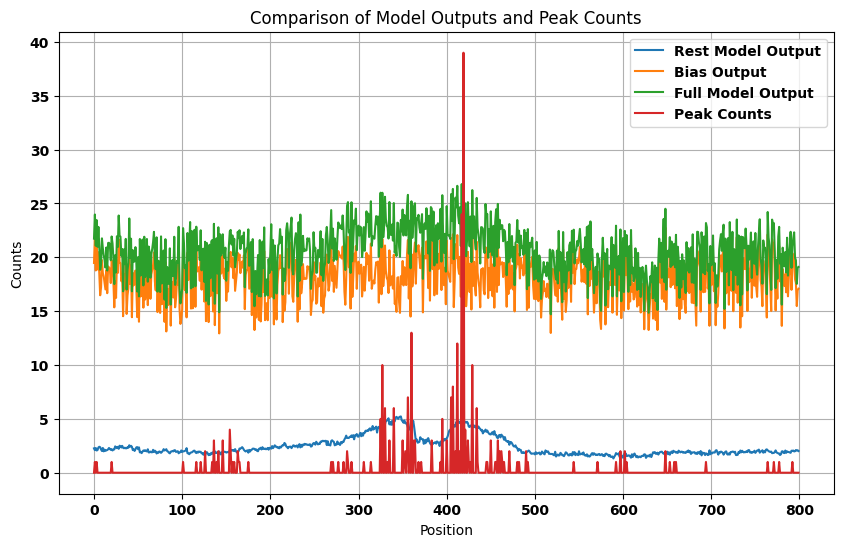

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
#let's plot the subparts again
plt.figure(figsize=(10, 6))

# Plot each series with a label and customize the appearance
plt.plot(other_model_output[0].squeeze(), label='Rest Model Output')
plt.plot(bias_output[0].squeeze(), label='Bias Output')
plt.plot(model_output[0].squeeze(), label='Full Model Output')
plt.plot(peak_cts[0].squeeze(), label='Peak Counts')

# Add a legend
plt.legend(loc='best')

# Add axis labels and a title
plt.xlabel('Position')
plt.ylabel('Counts')
plt.title('Comparison of Model Outputs and Peak Counts')

# Add grid for better readability
plt.grid(True)
plt.show()

In [15]:
plt.plot([0,1],[0,2])

In [27]:
#the final thing is we will save it all out
from tqdm import tqdm
import numpy as np
counts_matrix = np.zeros((peak_seqs.shape[0]))
profile_matrix = np.zeros((peak_seqs.shape[0], 800))

batch_size = 128

for i in tqdm(range(0,peak_seqs.shape[0], batch_size)):
    end = i+batch_size
    if end > peak_seqs.shape[0]:
        end = peak_seqs.shape[0]
    out = model.predict(peak_seqs[i:end])
    counts_matrix[i:end] = out[1].squeeze()
    profile_matrix[i:end] = out[0].squeeze()
    # print(out[1].shape, out[0].shape)
    # break
    # print(combined_out.shape, profile_out.shape, bias_out[0].shape)
    # print(counts_out.shape, out2[1].shape, bias_out[1].shape)

100%|██████████| 205/205 [00:58<00:00,  3.48it/s]


In [28]:
#print the number of 0 elements in the counts
print(np.sum(counts_matrix == 0))

0


In [29]:
#save ti out again
np.savez_compressed('/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/profile_chbpnet.npz', counts=counts_matrix, profile=profile_matrix)

# evaluate results!

In [31]:
#let's start by looking at the counts data
#first load in all the data
import numpy as np
nobias = np.load('/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/profile_nobias.npz')
bias = np.load('/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/profile_bias.npz')
chbpnet = np.load('/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/profile_chbpnet.npz')

In [39]:
#now load in the dataset as well
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.profile_atac import ProfileATAC
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
    characters=['A', 'C', 'G', 'T', 'N'],
    model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
    add_special_tokens=False,
    padding_side='left'
)
dataset = ProfileATAC(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='False')
#now produce a list of all the counts results
true_counts = np.zeros((len(dataset)))
true_profiles = np.zeros((len(dataset), 800))
for i in range(len(dataset)):
    true_counts[i] = dataset[i][1][1].item()
    true_profiles[i] = dataset[i][1][0].squeeze().cpu().detach().numpy()

In [40]:
#let's save it out
np.savez_compressed('/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/true_data.npz', counts=true_counts, profile=true_profiles)

In [5]:
bias['counts'].shape

(26172,)

In [6]:
true_counts.shape

(26172,)

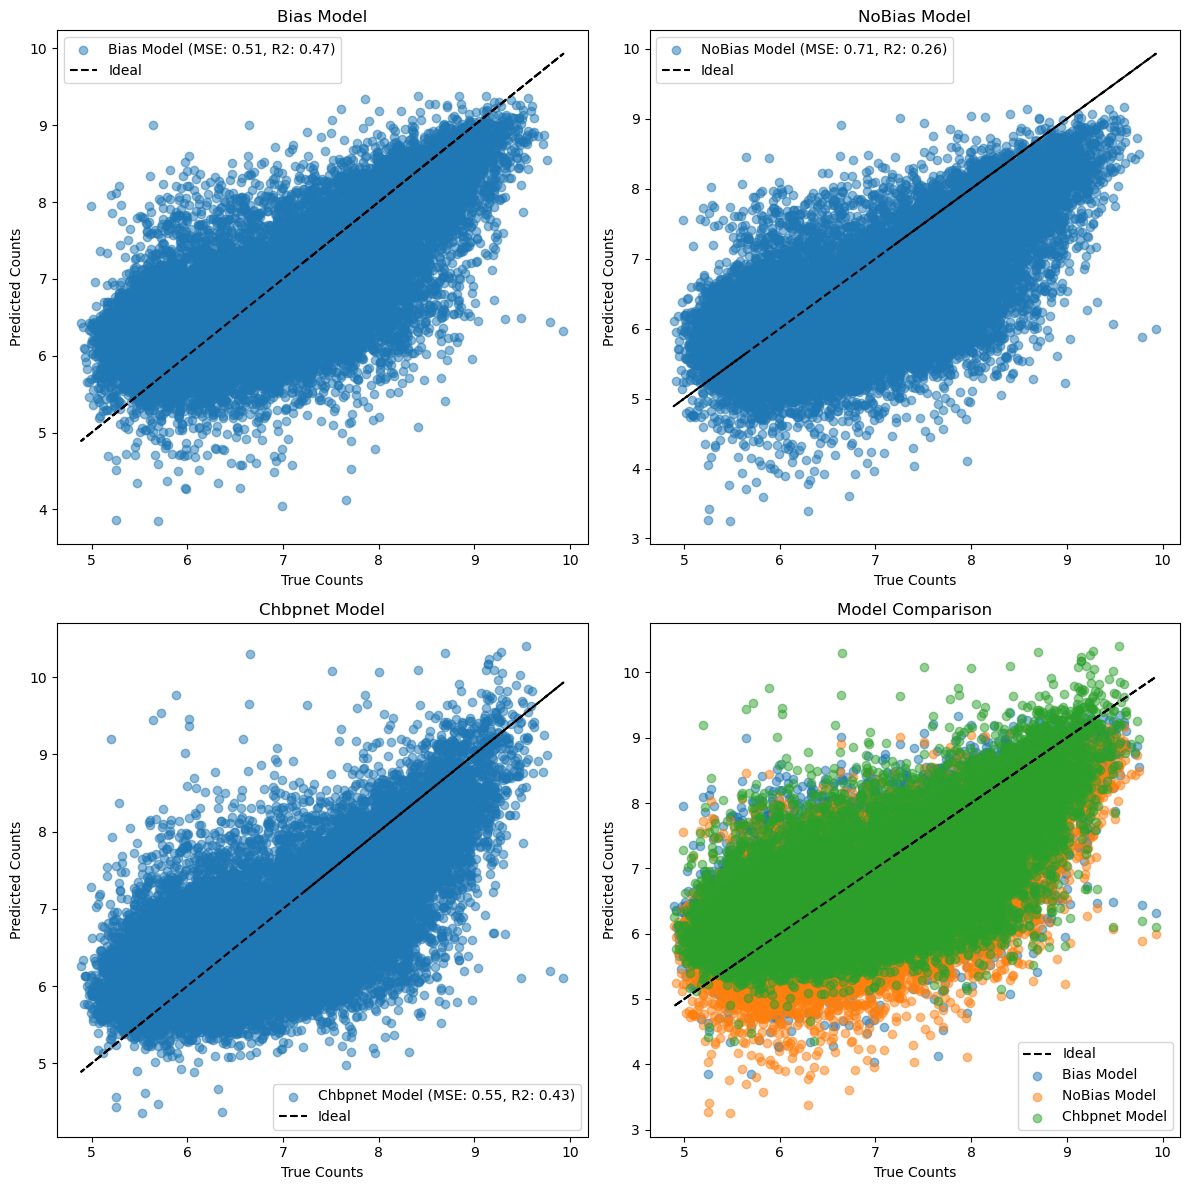

In [46]:
#now let's compare the models, first just the counts
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

bias_counts = bias['counts']
nobias_counts = nobias['counts']
chbpnet_counts = chbpnet['counts']

# Calculate summary statistics
bias_mse = mean_squared_error(true_counts, bias_counts)
nobias_mse = mean_squared_error(true_counts, nobias_counts)
chbpnet_mse = mean_squared_error(true_counts, chbpnet_counts)

bias_r2 = r2_score(true_counts, bias_counts)
nobias_r2 = r2_score(true_counts, nobias_counts)
chbpnet_r2 = r2_score(true_counts, chbpnet_counts)

# Create a figure
plt.figure(figsize=(12, 12))

# Scatter plots
plt.subplot(2, 2, 1)
plt.scatter(true_counts, bias_counts, alpha=0.5, label=f'Bias Model (MSE: {bias_mse:.2f}, R2: {bias_r2:.2f})')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('Bias Model')
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
#add the 1,1 line between the minimum and maximum
plt.plot()
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(true_counts, nobias_counts, alpha=0.5, label=f'NoBias Model (MSE: {nobias_mse:.2f}, R2: {nobias_r2:.2f})')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('NoBias Model')
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(true_counts, chbpnet_counts, alpha=0.5, label=f'Chbpnet Model (MSE: {chbpnet_mse:.2f}, R2: {chbpnet_r2:.2f})')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('Chbpnet Model')
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
plt.legend()

# Overlay plot
plt.subplot(2, 2, 4)
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
plt.scatter(true_counts, bias_counts, alpha=0.5, label='Bias Model')
plt.scatter(true_counts, nobias_counts, alpha=0.5, label='NoBias Model')
plt.scatter(true_counts, chbpnet_counts, alpha=0.5, label='Chbpnet Model')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('Model Comparison')
plt.legend()

plt.tight_layout()

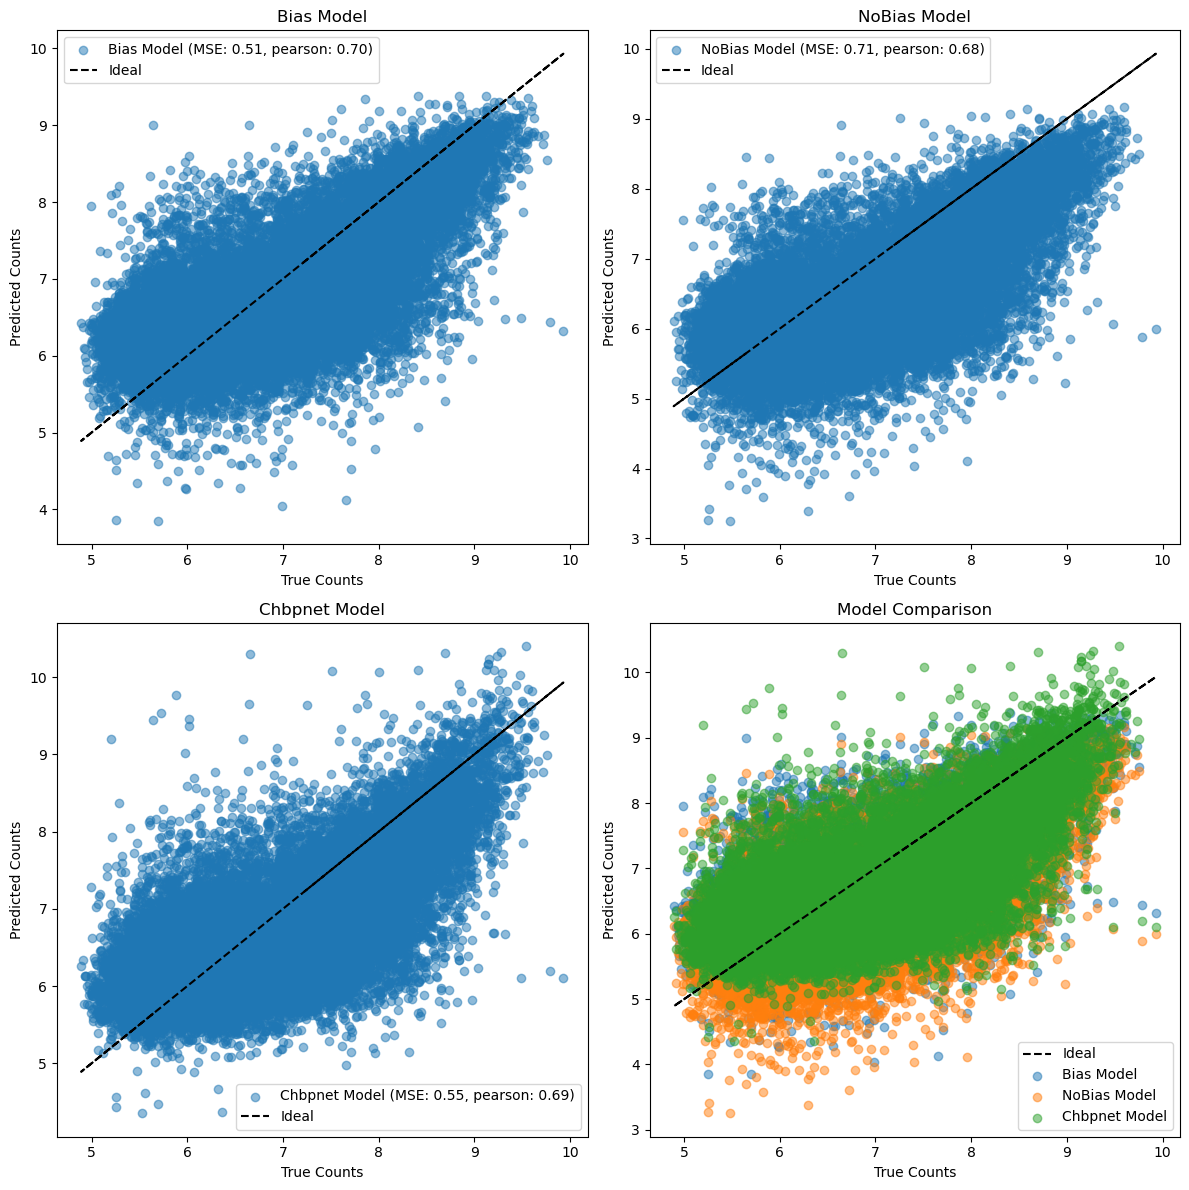

In [50]:
#now let's compare the models, first just the counts
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

bias_counts = bias['counts']
nobias_counts = nobias['counts']
chbpnet_counts = chbpnet['counts']

# Calculate summary statistics
bias_mse = mean_squared_error(true_counts, bias_counts)
nobias_mse = mean_squared_error(true_counts, nobias_counts)
chbpnet_mse = mean_squared_error(true_counts, chbpnet_counts)

#calculate the pearson correlation
bias_r2 = pearsonr(true_counts, bias_counts)[0]
nobias_r2 = pearsonr(true_counts, nobias_counts)[0]
chbpnet_r2 = pearsonr(true_counts, chbpnet_counts)[0]

# Create a figure
plt.figure(figsize=(12, 12))

# Scatter plots
plt.subplot(2, 2, 1)
plt.scatter(true_counts, bias_counts, alpha=0.5, label=f'Bias Model (MSE: {bias_mse:.2f}, pearson: {bias_r2:.2f})')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('Bias Model')
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
#add the 1,1 line between the minimum and maximum
plt.plot()
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(true_counts, nobias_counts, alpha=0.5, label=f'NoBias Model (MSE: {nobias_mse:.2f}, pearson: {nobias_r2:.2f})')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('NoBias Model')
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(true_counts, chbpnet_counts, alpha=0.5, label=f'Chbpnet Model (MSE: {chbpnet_mse:.2f}, pearson: {chbpnet_r2:.2f})')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('Chbpnet Model')
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
plt.legend()

# Overlay plot
plt.subplot(2, 2, 4)
plt.plot(true_counts, true_counts, 'k--', label='Ideal')
plt.scatter(true_counts, bias_counts, alpha=0.5, label='Bias Model')
plt.scatter(true_counts, nobias_counts, alpha=0.5, label='NoBias Model')
plt.scatter(true_counts, chbpnet_counts, alpha=0.5, label='Chbpnet Model')
plt.xlabel('True Counts')
plt.ylabel('Predicted Counts')
plt.title('Model Comparison')
plt.legend()

plt.tight_layout()

In [12]:
#plot the softmax
plt.plot(chbpnet['profile'], label='Chbpnet Profile')
plt.plot(bias['profile'], label='Bias Profile')
plt.plot(nobias['profile'], label='NoBias Profile')
plt.plot(true_counts[0], label='True Counts')

Error in callback <function _draw_all_if_interactive at 0x2b1128cec680> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [42]:
#let's plot an example profile again
#let's look at the profile output
import matplotlib.pyplot as plt
profile_out = chbpnet['profile'][0]
print(profile_out.shape)
#now we take the softmax
soft_out = torch.tensor(profile_out).softmax(dim=0)
print(soft_out.shape)

print(true_profiles.shape)
temp_true_counts = true_profiles[0]

(800,)
torch.Size([800])
(26172, 800)


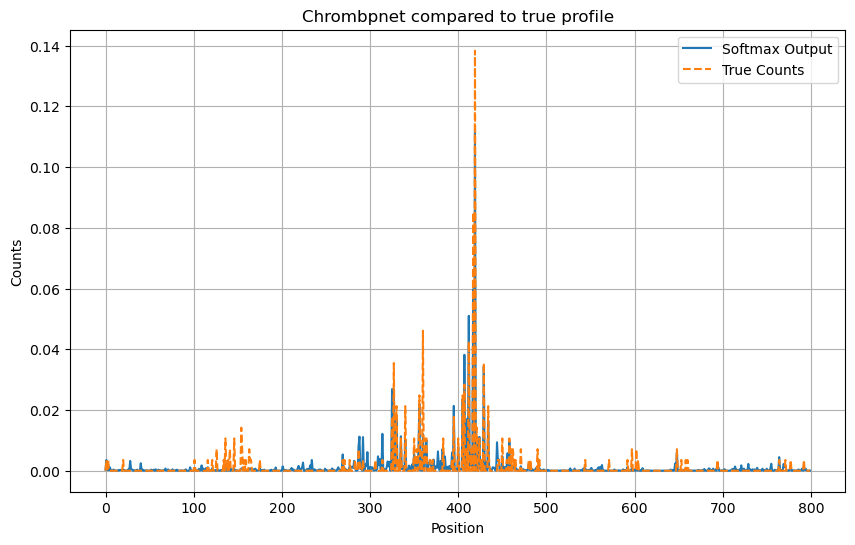

In [44]:
soft_out_np = soft_out.cpu().detach().numpy()
true_counts_np = temp_true_counts

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series with a label
soft_out_np = soft_out_np / soft_out_np.sum()
plt.plot(soft_out_np, label='Softmax Output', )
true_counts_np = true_counts_np / true_counts_np.sum()
plt.plot(true_counts_np, label='True Counts', linestyle='--')

# Add a legend
plt.legend(loc='best')

# Add axis labels and a title
plt.xlabel('Position')
plt.ylabel('Counts')
plt.title('Chrombpnet compared to true profile')

# Add grid for better readability
plt.grid(True)

(800,)
torch.Size([800])
(26172, 800)


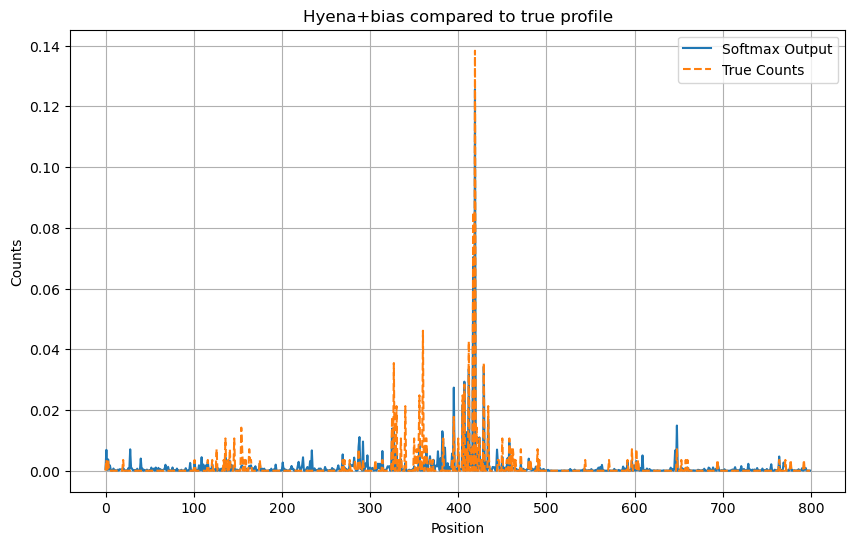

In [48]:
#let's plot an example profile again
#let's look at the profile output
profile_out = bias['profile'][0]
print(profile_out.shape)
#now we take the softmax
soft_out = torch.tensor(profile_out).softmax(dim=0)
print(soft_out.shape)

print(true_profiles.shape)
temp_true_counts = true_profiles[0]
soft_out_np = soft_out.cpu().detach().numpy()
true_counts_np = temp_true_counts

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series with a label
soft_out_np = soft_out_np / soft_out_np.sum()
plt.plot(soft_out_np, label='Softmax Output', )
true_counts_np = true_counts_np / true_counts_np.sum()
plt.plot(true_counts_np, label='True Counts', linestyle='--')

# Add a legend
plt.legend(loc='best')

# Add axis labels and a title
plt.xlabel('Position')
plt.ylabel('Counts')
plt.title('Hyena+bias compared to true profile')

# Add grid for better readability
plt.grid(True)

(800,)
torch.Size([800])
(26172, 800)


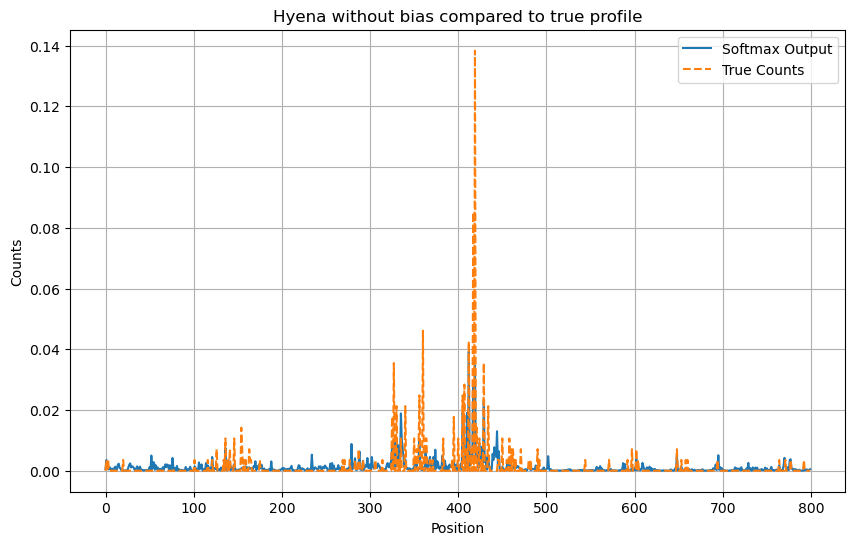

In [49]:
#let's plot an example profile again
#let's look at the profile output
profile_out = nobias['profile'][0]
print(profile_out.shape)
#now we take the softmax
soft_out = torch.tensor(profile_out).softmax(dim=0)
print(soft_out.shape)

print(true_profiles.shape)
temp_true_counts = true_profiles[0]
soft_out_np = soft_out.cpu().detach().numpy()
true_counts_np = temp_true_counts

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series with a label
soft_out_np = soft_out_np / soft_out_np.sum()
plt.plot(soft_out_np, label='Softmax Output', )
true_counts_np = true_counts_np / true_counts_np.sum()
plt.plot(true_counts_np, label='True Counts', linestyle='--')

# Add a legend
plt.legend(loc='best')

# Add axis labels and a title
plt.xlabel('Position')
plt.ylabel('Counts')
plt.title('Hyena without bias compared to true profile')

# Add grid for better readability
plt.grid(True)

In [53]:
#now let's do a basic correlation, start with 
#now we can do the correlation
from scipy.stats import pearsonr
from tqdm import tqdm
corr_values = np.zeros((bias['profile'].shape[0], 3))
for i in tqdm(range(bias['profile'].shape[0])):
    corr_values[i,0] = pearsonr(bias['profile'][i], true_profiles[i])[0]
    corr_values[i,1] = pearsonr(nobias['profile'][i], true_profiles[i])[0]
    corr_values[i,2] = pearsonr(chbpnet['profile'][i], true_profiles[i])[0]
    if i == 10:
        break

  0%|          | 10/26172 [00:35<26:03:28,  3.59s/it]


In [54]:
print(corr_values[:10,:])

[[0.34169698 0.32362457 0.35487771]
 [0.39171035 0.36127105 0.38240881]
 [0.47076105 0.44267817 0.49355279]
 [0.47033431 0.38219301 0.47081611]
 [0.4457012  0.38475371 0.45957419]
 [0.5092814  0.38712972 0.51860972]
 [0.49090809 0.36366194 0.50375073]
 [0.44249225 0.36255537 0.44697109]
 [0.48767036 0.39658691 0.48696791]
 [0.50165985 0.40106109 0.5025564 ]]


In [56]:
#let's just create a function to calculate pairwise correlations

def pearsonr2(x, y):
    # Compute Pearson correlation coefficient. We can't use `cov` or `corrcoef`
    # because they want to compute everything pairwise between rows of a
    # stacked x and y.
    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(x.shape[-1]-1)
    sx = np.std(x, ddof=1, axis=-1)
    sy = np.std(y, ddof=1, axis=-1)
    rho = cov/(sx * sy)

    return rho

x = bias['profile'][:10]
y = true_profiles[:10]
test_out = pearsonr2(x,y)
print(test_out)


[0.34169698 0.39171035 0.47076105 0.47033431 0.4457012  0.5092814
 0.49090809 0.44249225 0.48767036 0.50165985]


In [58]:
np.allclose(test_out, corr_values[:10,0])

True

In [59]:
#now test this function on the whole thing
def pearsonr2(x, y):
    # Compute Pearson correlation coefficient. We can't use `cov` or `corrcoef`
    # because they want to compute everything pairwise between rows of a
    # stacked x and y.
    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(x.shape[-1]-1)
    sx = np.std(x, ddof=1, axis=-1)
    sy = np.std(y, ddof=1, axis=-1)
    rho = cov/(sx * sy)

    return rho
cbpnet_results = pearsonr2(chbpnet['profile'], true_profiles)
print('done 1')
bias_hyena = pearsonr2(bias['profile'], true_profiles)
print('done2')
nobias_hyena = pearsonr2(nobias['profile'], true_profiles)

#so fast!!!

done 1
done2


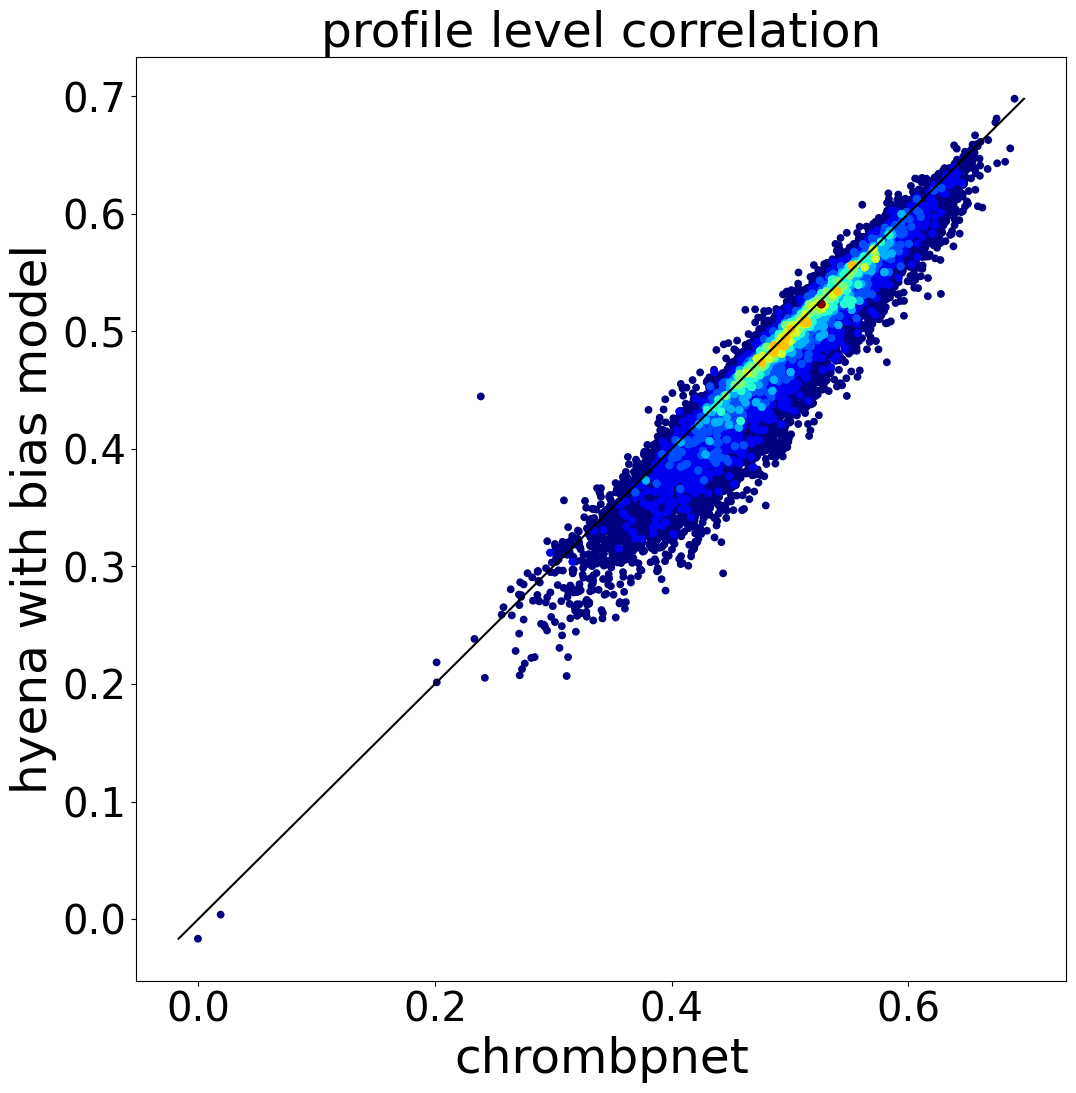

In [60]:
#now let's do the plot

import matplotlib.pyplot as plt
x,y = cbpnet_results, bias_hyena
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('chrombpnet', fontsize=35)
plt.ylabel('hyena with bias model', fontsize=35)
plt.title('profile level correlation', fontsize=35)
plt.tick_params(labelsize=29)

Text(0.5, 1.0, 'Profile Level Correlation')

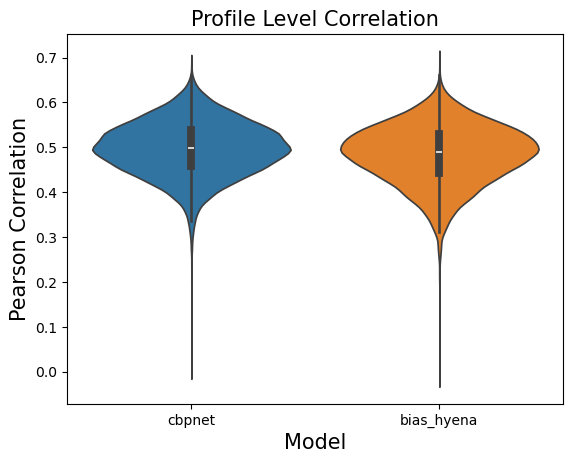

In [62]:
x,y = cbpnet_results, bias_hyena
#do a violin plot
import seaborn as sns
import pandas as pd
df = pd.DataFrame(data={'cbpnet':x, 'bias_hyena':y})
sns.violinplot(data=df)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Pearson Correlation', fontsize=15)
plt.title('Profile Level Correlation', fontsize=15)

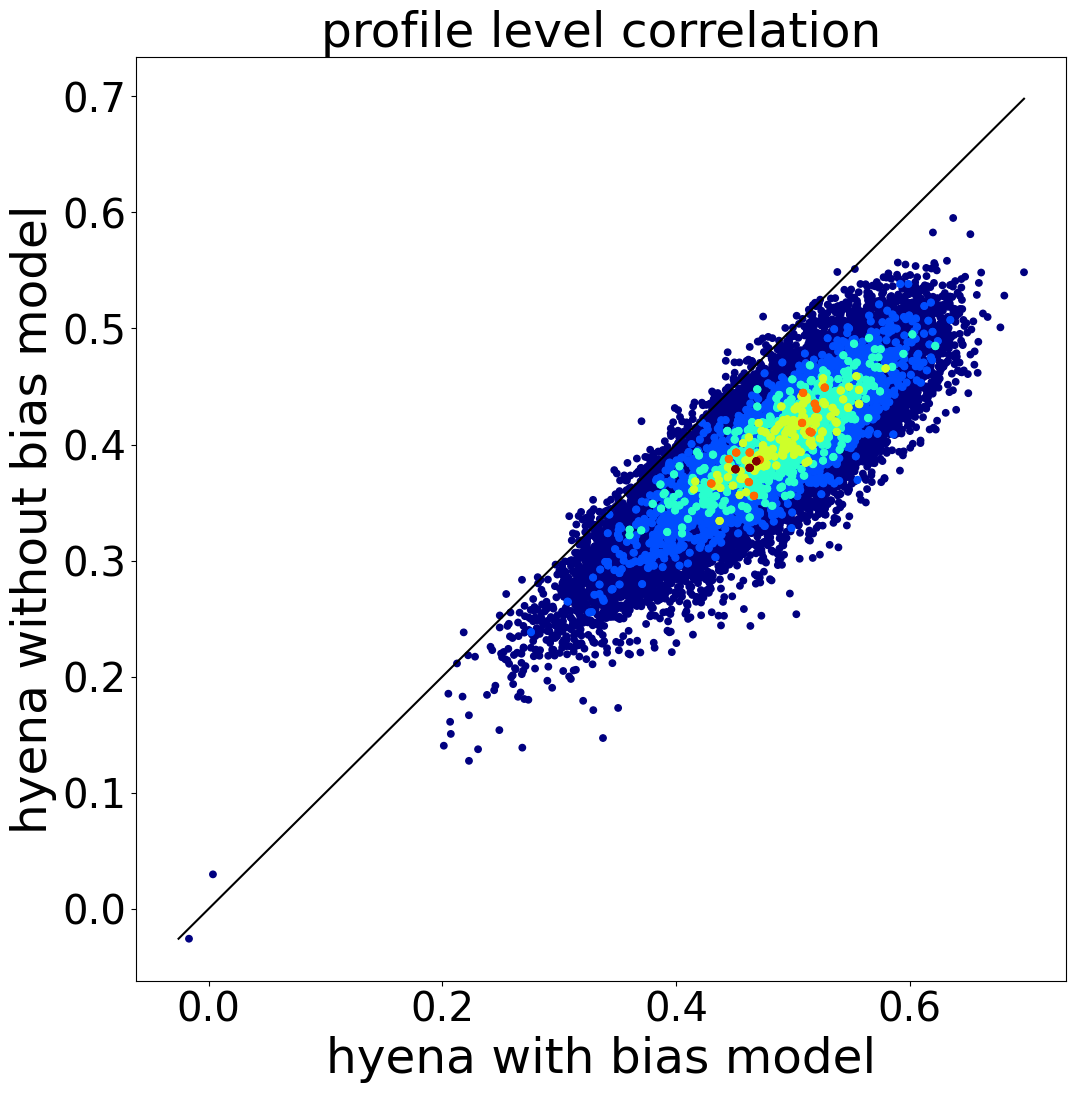

In [61]:
#now let's do the plot

import matplotlib.pyplot as plt
x,y = bias_hyena, nobias_hyena
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('hyena with bias model', fontsize=35)
plt.ylabel('hyena without bias model', fontsize=35)
plt.title('profile level correlation', fontsize=35)
plt.tick_params(labelsize=29)